# PreTrain

In [1]:
from model.sswae_dev2_1 import SSWAE_HSIC_MNIST as cur_model

import os, sys, configparser, logging, argparse, time
sys.path.append('/'.join(os.getcwd().split('/')[:-2]))

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim

from XAE.dataset import rmMNIST
from XAE.dataset import MNIST
from XAE.util import init_params

import numpy as np
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')
y_dim = 9

d = 64
embed_data = nn.Sequential(
    nn.Conv2d(1, d, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(d),
    nn.ReLU(True),

    nn.Conv2d(d, d, kernel_size = 4, padding = 'same', bias = False),
    nn.BatchNorm2d(d),
    nn.ReLU(True),

    nn.Conv2d(d, 2*d, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(2*d),
    nn.ReLU(True),

    nn.Conv2d(2*d, 2*d, kernel_size = 4, padding = 'same', bias = False),
    nn.BatchNorm2d(2*d),
    nn.ReLU(True),

    nn.Flatten(),
).to(device)

embed_condition = nn.Sequential(
    nn.Linear(49*2*d, d),
    nn.BatchNorm1d(d),
    nn.ReLU(True),
    
    nn.Linear(d, y_dim),
).to(device)

enc_activation = nn.Sequential(
    nn.BatchNorm1d(y_dim),
    nn.ReLU(True),
    nn.Linear(y_dim, 10),
).to(device)

init_params(embed_data)
init_params(embed_condition)
init_params(enc_activation)

In [3]:
labeled_class = [0,1,2,3,4,5,6,7,8,9]
train_data = rmMNIST('./data/MNIST', train = True, label = True, aux = [labeled_class, []], portion = 1.0)
train_generator = torch.utils.data.DataLoader(train_data, 100, num_workers = 5, shuffle = True, pin_memory=True, drop_last=True)

In [4]:
def kk(x, y, diag = True):
    stat = 0.
    for scale in [.1, .2, .5, 1., 2., 5., 10.]:
        C = scale*2*y_dim*2
        kernel = (C/(C + (x.unsqueeze(0) - y.unsqueeze(1)).pow(2).sum(dim = 2)))
        if diag:
            stat += kernel.sum()
        else:
            stat += kernel.sum() - kernel.diag().sum()
    return stat

In [5]:
epoch = 20
opt = optim.Adam(list(embed_data.parameters()) + list(embed_condition.parameters()) + list(enc_activation.parameters()), lr = 1e-3, betas = (0.9, 0.999))
crit = nn.CrossEntropyLoss()
running_loss = 0.0

for k in range(epoch):
    for i, (data, condition) in enumerate(train_generator):
        opt.zero_grad()
        n = len(data)
        x = data.to(device)
        y = condition.to(device)
        
        xx = embed_condition(embed_data(x))
        output = enc_activation(xx)
        loss = crit(output, y)
        loss.backward()
        opt.step()
        running_loss += loss.item()
        
    print('[%d] loss: %.3f' % (k + 1, running_loss / len(train_generator)))
    running_loss = 0.0

[1] loss: 1.233
[2] loss: 0.135
[3] loss: 0.044
[4] loss: 0.026
[5] loss: 0.018
[6] loss: 0.013
[7] loss: 0.010
[8] loss: 0.009
[9] loss: 0.009
[10] loss: 0.006
[11] loss: 0.006
[12] loss: 0.005
[13] loss: 0.005
[14] loss: 0.003
[15] loss: 0.001
[16] loss: 0.007
[17] loss: 0.003
[18] loss: 0.003
[19] loss: 0.004
[20] loss: 0.003


In [6]:
batch_size = 100
test_data = MNIST('./data/MNIST', train = False, label = True)
test_generator = torch.utils.data.DataLoader(test_data, batch_size, num_workers = 5, shuffle = False, pin_memory=True, drop_last=True)
n = len(test_generator)

a, b = next(iter(test_generator))
embed_condition(embed_data(a.to(device))).shape

torch.Size([100, 9])

In [7]:
f1 = np.zeros((0, 10))
f2 = np.zeros((0, y_dim))

i = 0
for a, b in test_generator:
    f1x = b.to('cpu').detach().numpy()
    f2x = embed_condition(embed_data(a.to(device))).to('cpu').detach().numpy()
    f1 = np.concatenate((f1, f1x), axis = 0)
    f2 = np.concatenate((f2, f2x), axis = 0)
    i += 1
    if i == 5:
        break
        
digit = np.arange(10)
lab = [digit[l.astype(np.bool_)] for l in f1]
lab = np.concatenate(lab)

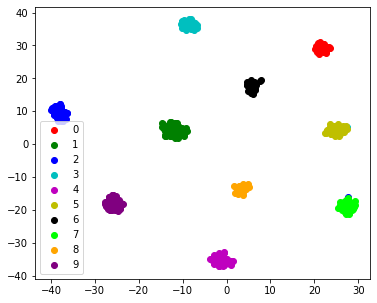

In [8]:
tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(f2)

target_ids = list(range(10))

plt.figure(figsize=(6, 5))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'lime', 'orange', 'purple'
for i, c in zip(target_ids, colors):
    plt.scatter(X_2d[lab == i, 0], X_2d[lab == i, 1], c=c, label=str(i))
plt.legend()
plt.show()

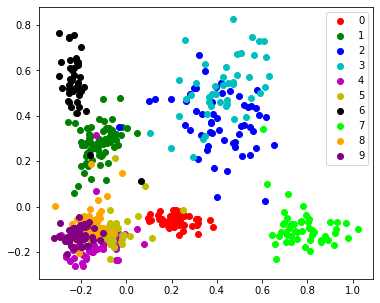

In [9]:
plt.figure(figsize=(6, 5))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'lime', 'orange', 'purple'
for i, c in zip(target_ids, colors):
    plt.scatter(f2[lab == i, 0], f2[lab == i, 2], c=c, label=str(i))
plt.legend()
plt.show()

In [10]:
labeled_class = [0,1,2,3,4,5,6,7,8,9]
train_data = rmMNIST('./data/MNIST', train = True, label = True, aux = [labeled_class, []], portion = 1.0, class_no = True)
train_generator = torch.utils.data.DataLoader(train_data, 100, num_workers = 5, shuffle = True, pin_memory=True, drop_last=True)

In [11]:
ys = np.zeros((10, y_dim))
cs = np.zeros(10)
covs = np.zeros((10, y_dim, y_dim))

for data, condition in train_generator:
    n = len(data)
    x = data.to(device)
    y = condition.to(device)
    z = embed_condition(embed_data(x))
    labs, idxs, counts = y.unique(dim = 0, return_inverse = True, return_counts = True)
    idxs = labs[idxs].view(n,1).expand(-1, y_dim)
    cc = torch.zeros((10, y_dim), dtype = torch.float).to(device).scatter_add_(0, idxs, z)
    ys += cc.detach().to('cpu').numpy()
    cs += counts[labs].detach().to('cpu').numpy()
    
    for i in range(10):
        cov = torch.cov(z[y==i,:].T, correction=0) * torch.sum(y==i)
        covs[i,:,:] += cov.detach().to('cpu').numpy()

In [12]:
w1 = torch.Tensor(ys.transpose()/cs)
w1

tensor([[ 0.2031, -0.1235,  0.4026,  0.4340, -0.1638, -0.0715, -0.2262,  0.7674,
         -0.1672, -0.2132],
        [-0.2212, -0.1471,  0.3691, -0.3014,  0.3457, -0.2772, -0.1820, -0.2264,
          0.4577, -0.2041],
        [-0.0666,  0.2923,  0.3417,  0.5432, -0.1916, -0.0977,  0.5485, -0.1118,
         -0.0611, -0.1219],
        [ 0.3612, -0.2004,  0.2486,  0.2548, -0.2507, -0.2213, -0.1921, -0.2367,
         -0.0816,  0.3857],
        [-0.1987, -0.2233,  0.2494, -0.2396,  0.2057,  0.4363,  0.1690, -0.2520,
         -0.3077,  0.0445],
        [-0.1697,  0.4207, -0.3179,  0.4279, -0.2064,  0.4274, -0.1954, -0.2111,
          0.4176, -0.1640],
        [-0.1797,  0.2364, -0.3648,  0.4088, -0.2683,  0.5224, -0.1926, -0.2063,
          0.3673, -0.1619],
        [ 0.3983,  0.4113, -0.1714, -0.2174,  0.4733, -0.1517,  0.3037, -0.1748,
         -0.1385, -0.1636],
        [-0.1996,  0.4546, -0.1379, -0.1152,  0.2029, -0.1358, -0.1827,  0.4087,
         -0.1003,  0.5096]])

In [13]:
f1 = nn.Linear(10, y_dim, bias = False)
f1.weight.data = w1
torch.save(f1.state_dict(), f'./result/mu_{y_dim}.pt')

In [14]:
w2 = torch.tensor((covs.T / (cs - 1)).T)

In [15]:
for i in range(10):
    e, v = torch.symeig(w2[i,:,:], eigenvectors = True)
    w2[i,:,:] = v @ torch.diag(torch.sqrt(e)) @ v.T

In [16]:
f2 = nn.ConvTranspose2d(10, 1, y_dim, bias=False)
f2.weight.data = w2.view(10,1,y_dim,y_dim)
torch.save(f2.state_dict(), f'./result/cov_{y_dim}.pt')

# Train

In [3]:
from XAE.logging_daily import logging_daily

is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

logger = logging_daily('./config/log_info.yaml')
log = logger.get_logging()
log.setLevel(logging.INFO)

cfg = configparser.ConfigParser()
cfg.read('./config/sswae_dev2_1_15.cfg')

['./config/sswae_dev2_1_15.cfg']

In [4]:
mm = cur_model(cfg, log, device = device)

mm.gm.mu.load_state_dict(torch.load(f'./result/mu_{mm.y_dim}.pt'))
mm.gm.cov.load_state_dict(torch.load(f'./result/cov_{mm.y_dim}.pt'))

mm.train()
# mm.load('./%s' % (cfg['path_info']['save_path']))

[default |INFO|_base_model.py:27] ------------------------------------------------------------
[default |INFO|_base_model.py:29] model_name : SSWAE_HSIC_MNIST
[default |INFO|_base_model.py:29] train_data : rmMNIST
[default |INFO|_base_model.py:29] train_data_label : True
[default |INFO|_base_model.py:29] z_sampler : gaus
[default |INFO|_base_model.py:29] z_dim : 5
[default |INFO|_base_model.py:29] y_sampler : gaus
[default |INFO|_base_model.py:29] y_dim : 9
[default |INFO|_base_model.py:29] labeled_class : 0,1,2,3,4,5,6,7,8,9
[default |INFO|_base_model.py:29] unlabeled_class : 
[default |INFO|_base_model.py:29] test_class : 
[default |INFO|_base_model.py:29] portion : 1.0
[default |INFO|_base_model.py:29] encoder_pretrain : False
[default |INFO|_base_model.py:29] encoder_pretrain_step : 3
[default |INFO|_base_model.py:29] lr : 5e-4
[default |INFO|_base_model.py:29] beta1 : 0.5
[default |INFO|_base_model.py:29] lr_adv : 2e-4
[default |INFO|_base_model.py:29] beta1_adv : 0.5
[default |IN

[default |INFO|model.py:1280] [01/80]  loss: 2.438785e-01  D: 6.922999e-01  D2: 4.222541e-02  D3: 3.308305e-03
test loss: 1.760746e-01  D: 6.936319e-01  D2: 1.264290e-02  D3: 6.736982e-03


[default |INFO|model.py:1280] [02/80]  loss: 1.667209e-01  D: 6.963457e-01  D2: 7.049708e-03  D3: 7.101341e-03
test loss: 1.788100e-01  D: 6.403333e-01  D2: -2.223778e-04  D3: 1.011164e-02


[default |INFO|model.py:1280] [03/80]  loss: 1.471326e-01  D: 6.939788e-01  D2: -4.354620e-04  D3: 6.698693e-03
test loss: 1.369037e-01  D: 6.958812e-01  D2: -7.252979e-04  D3: 9.573062e-03


[default |INFO|model.py:1280] [04/80]  loss: 1.170756e-01  D: 6.933555e-01  D2: -1.406229e-03  D3: 1.003135e-02
test loss: 1.053703e-01  D: 6.967478e-01  D2: -2.385101e-03  D3: 1.204840e-02


[default |INFO|model.py:1280] [05/80]  loss: 1.099947e-01  D: 6.988104e-01  D2: -2.296608e-03  D3: 1.246607e-02
test loss: 9.366003e-02  D: 6.656128e-01  D2: -2.972898e-03  D3: 1.184021e-02


[default |INFO|model.py:1280] [06/80]  loss: 9.328853e-02  D: 6.958336e-01  D2: -3.083202e-03  D3: 1.266896e-02
test loss: 1.006585e-01  D: 7.486645e-01  D2: -3.182030e-03  D3: 1.771401e-02


[default |INFO|model.py:1280] [07/80]  loss: 8.540662e-02  D: 6.943276e-01  D2: -3.904988e-03  D3: 1.273368e-02
test loss: 7.867267e-02  D: 6.773951e-01  D2: -3.386936e-03  D3: 1.037619e-02


[default |INFO|model.py:1280] [08/80]  loss: 7.767705e-02  D: 6.937515e-01  D2: -3.923068e-03  D3: 1.534836e-02
test loss: 7.260205e-02  D: 7.093260e-01  D2: -3.894854e-03  D3: 1.602535e-02


[default |INFO|model.py:1280] [09/80]  loss: 7.300615e-02  D: 6.935743e-01  D2: -4.134684e-03  D3: 1.441385e-02
test loss: 7.349342e-02  D: 6.910617e-01  D2: -4.649734e-03  D3: 1.486927e-02


[default |INFO|model.py:1280] [10/80]  loss: 6.925761e-02  D: 6.937015e-01  D2: -4.524870e-03  D3: 1.434227e-02
test loss: 6.822388e-02  D: 6.953014e-01  D2: -4.241571e-03  D3: 1.441355e-02


[default |INFO|model.py:1280] [11/80]  loss: 6.767196e-02  D: 6.939985e-01  D2: -4.920697e-03  D3: 1.427157e-02
test loss: 6.567381e-02  D: 6.795229e-01  D2: -4.995832e-03  D3: 1.399249e-02


[default |INFO|model.py:1280] [12/80]  loss: 6.719378e-02  D: 6.945318e-01  D2: -5.175422e-03  D3: 1.367169e-02
test loss: 7.823155e-02  D: 6.724900e-01  D2: -3.876181e-03  D3: 1.406327e-02


[default |INFO|model.py:1280] [13/80]  loss: 6.506385e-02  D: 6.937289e-01  D2: -5.036093e-03  D3: 1.472592e-02
test loss: 6.202006e-02  D: 6.806301e-01  D2: -5.451260e-03  D3: 1.414507e-02


[default |INFO|model.py:1280] [14/80]  loss: 6.298277e-02  D: 6.941146e-01  D2: -5.394613e-03  D3: 1.411526e-02
test loss: 6.142707e-02  D: 6.986106e-01  D2: -5.667839e-03  D3: 1.524209e-02


[default |INFO|model.py:1280] [15/80]  loss: 6.052710e-02  D: 6.943744e-01  D2: -5.733178e-03  D3: 1.432082e-02
test loss: 6.033941e-02  D: 7.101685e-01  D2: -5.590229e-03  D3: 1.380209e-02


[default |INFO|model.py:1280] [16/80]  loss: 6.114473e-02  D: 6.935674e-01  D2: -5.806745e-03  D3: 1.376615e-02
test loss: 5.939181e-02  D: 6.795937e-01  D2: -5.849447e-03  D3: 1.422866e-02


[default |INFO|model.py:1280] [17/80]  loss: 6.033675e-02  D: 6.945346e-01  D2: -5.851240e-03  D3: 1.364299e-02
test loss: 6.096369e-02  D: 7.047758e-01  D2: -6.303606e-03  D3: 1.314611e-02


[default |INFO|model.py:1280] [18/80]  loss: 5.813111e-02  D: 6.934360e-01  D2: -6.333141e-03  D3: 1.400245e-02
test loss: 6.063486e-02  D: 7.198224e-01  D2: -6.128464e-03  D3: 1.394583e-02


[default |INFO|model.py:1280] [19/80]  loss: 5.738198e-02  D: 6.947811e-01  D2: -6.154130e-03  D3: 1.377616e-02
test loss: 5.660939e-02  D: 6.821243e-01  D2: -6.025267e-03  D3: 1.380418e-02


[default |INFO|model.py:1280] [20/80]  loss: 5.503480e-02  D: 6.932235e-01  D2: -6.268843e-03  D3: 1.426170e-02
test loss: 5.459477e-02  D: 6.913323e-01  D2: -6.016140e-03  D3: 1.401845e-02


[default |INFO|model.py:1280] [21/80]  loss: 5.656484e-02  D: 6.947180e-01  D2: -6.475697e-03  D3: 1.363594e-02
test loss: 5.651741e-02  D: 6.743310e-01  D2: -6.488390e-03  D3: 1.585207e-02


[default |INFO|model.py:1280] [22/80]  loss: 5.454021e-02  D: 6.934441e-01  D2: -6.701080e-03  D3: 1.379056e-02
test loss: 5.454530e-02  D: 6.907558e-01  D2: -6.538811e-03  D3: 1.373656e-02


[default |INFO|model.py:1280] [23/80]  loss: 5.319813e-02  D: 6.939161e-01  D2: -6.859643e-03  D3: 1.370549e-02
test loss: 5.359479e-02  D: 7.023652e-01  D2: -7.251263e-03  D3: 1.418202e-02


[default |INFO|model.py:1280] [24/80]  loss: 5.266921e-02  D: 6.942163e-01  D2: -6.974773e-03  D3: 1.383532e-02
test loss: 5.131649e-02  D: 6.984774e-01  D2: -7.528038e-03  D3: 1.414304e-02


[default |INFO|model.py:1280] [25/80]  loss: 5.188236e-02  D: 6.935136e-01  D2: -7.156906e-03  D3: 1.381416e-02
test loss: 5.459693e-02  D: 6.807507e-01  D2: -7.126598e-03  D3: 1.396119e-02


[default |INFO|model.py:1280] [26/80]  loss: 5.110906e-02  D: 6.935613e-01  D2: -7.265485e-03  D3: 1.401591e-02
test loss: 5.210812e-02  D: 6.946324e-01  D2: -6.939459e-03  D3: 1.292972e-02


[default |INFO|model.py:1280] [27/80]  loss: 5.073682e-02  D: 6.931338e-01  D2: -7.355235e-03  D3: 1.388094e-02
test loss: 5.559880e-02  D: 6.862543e-01  D2: -7.846203e-03  D3: 1.105599e-02


[default |INFO|model.py:1280] [28/80]  loss: 5.160957e-02  D: 6.936156e-01  D2: -7.439507e-03  D3: 1.342323e-02
test loss: 5.129322e-02  D: 7.062006e-01  D2: -7.619267e-03  D3: 1.494250e-02


[default |INFO|model.py:1280] [29/80]  loss: 5.217912e-02  D: 6.938316e-01  D2: -7.505383e-03  D3: 1.349390e-02
test loss: 5.098111e-02  D: 6.980935e-01  D2: -7.459803e-03  D3: 1.519573e-02


[default |INFO|model.py:1280] [30/80]  loss: 5.038023e-02  D: 6.940666e-01  D2: -7.719237e-03  D3: 1.348939e-02
test loss: 4.856596e-02  D: 6.915438e-01  D2: -8.020248e-03  D3: 1.314569e-02


[default |INFO|model.py:1280] [31/80]  loss: 4.964605e-02  D: 6.933940e-01  D2: -7.779406e-03  D3: 1.381748e-02
test loss: 4.878744e-02  D: 6.851508e-01  D2: -7.791719e-03  D3: 1.399179e-02


[default |INFO|model.py:1280] [32/80]  loss: 4.838959e-02  D: 6.933162e-01  D2: -7.855659e-03  D3: 1.386706e-02
test loss: 5.132022e-02  D: 6.925673e-01  D2: -8.021231e-03  D3: 1.270714e-02


[default |INFO|model.py:1280] [33/80]  loss: 4.990435e-02  D: 6.935009e-01  D2: -8.016589e-03  D3: 1.362260e-02
test loss: 4.965239e-02  D: 7.072438e-01  D2: -8.301744e-03  D3: 1.208953e-02


[default |INFO|model.py:1280] [34/80]  loss: 4.810806e-02  D: 6.936637e-01  D2: -8.188696e-03  D3: 1.352987e-02
test loss: 4.814754e-02  D: 6.877807e-01  D2: -8.304548e-03  D3: 1.309878e-02


[default |INFO|model.py:1280] [35/80]  loss: 4.796436e-02  D: 6.937386e-01  D2: -8.219353e-03  D3: 1.348917e-02
test loss: 5.040858e-02  D: 6.976950e-01  D2: -8.347874e-03  D3: 1.415061e-02


[default |INFO|model.py:1280] [36/80]  loss: 4.798144e-02  D: 6.938005e-01  D2: -8.304939e-03  D3: 1.343785e-02
test loss: 4.854188e-02  D: 6.930823e-01  D2: -8.095207e-03  D3: 1.536999e-02


[default |INFO|model.py:1280] [37/80]  loss: 4.785801e-02  D: 6.931487e-01  D2: -8.317389e-03  D3: 1.353409e-02
test loss: 4.708693e-02  D: 6.923006e-01  D2: -8.630886e-03  D3: 1.411661e-02


[default |INFO|model.py:1280] [38/80]  loss: 4.729455e-02  D: 6.931490e-01  D2: -8.431225e-03  D3: 1.363046e-02
test loss: 4.824415e-02  D: 6.940554e-01  D2: -8.623924e-03  D3: 1.389499e-02


[default |INFO|model.py:1280] [39/80]  loss: 4.759619e-02  D: 6.938465e-01  D2: -8.525861e-03  D3: 1.337301e-02
test loss: 5.679786e-02  D: 6.713266e-01  D2: -8.080578e-03  D3: 1.383825e-02


[default |INFO|model.py:1280] [40/80]  loss: 4.806018e-02  D: 6.933987e-01  D2: -8.623284e-03  D3: 1.344518e-02
test loss: 4.871684e-02  D: 6.945023e-01  D2: -8.915691e-03  D3: 1.375948e-02


[default |INFO|model.py:1280] [41/80]  loss: 4.689560e-02  D: 6.933109e-01  D2: -8.751218e-03  D3: 1.338592e-02
test loss: 4.824723e-02  D: 6.950271e-01  D2: -8.747625e-03  D3: 1.397618e-02


[default |INFO|model.py:1280] [42/80]  loss: 4.679312e-02  D: 6.935323e-01  D2: -8.764722e-03  D3: 1.344286e-02
test loss: 4.780503e-02  D: 6.888895e-01  D2: -8.826056e-03  D3: 1.233679e-02


[default |INFO|model.py:1280] [43/80]  loss: 4.744053e-02  D: 6.933851e-01  D2: -8.894337e-03  D3: 1.311873e-02
test loss: 4.915558e-02  D: 6.966099e-01  D2: -8.940458e-03  D3: 1.193213e-02


[default |INFO|model.py:1280] [44/80]  loss: 4.648646e-02  D: 6.932432e-01  D2: -8.905007e-03  D3: 1.342031e-02
test loss: 4.691315e-02  D: 6.858084e-01  D2: -9.240980e-03  D3: 1.330831e-02


[default |INFO|model.py:1280] [45/80]  loss: 4.594908e-02  D: 6.933875e-01  D2: -8.957319e-03  D3: 1.348964e-02
test loss: 4.747728e-02  D: 7.050142e-01  D2: -8.993692e-03  D3: 1.515162e-02


[default |INFO|model.py:1280] [46/80]  loss: 4.640461e-02  D: 6.934459e-01  D2: -9.026640e-03  D3: 1.332313e-02
test loss: 4.826115e-02  D: 6.861641e-01  D2: -9.339809e-03  D3: 1.389482e-02


[default |INFO|model.py:1280] [47/80]  loss: 4.579322e-02  D: 6.931080e-01  D2: -9.051986e-03  D3: 1.331383e-02
test loss: 4.780945e-02  D: 7.080602e-01  D2: -9.015446e-03  D3: 1.345131e-02


[default |INFO|model.py:1280] [48/80]  loss: 4.588878e-02  D: 6.937801e-01  D2: -9.168773e-03  D3: 1.327206e-02
test loss: 4.669663e-02  D: 6.983632e-01  D2: -9.208632e-03  D3: 1.326595e-02


[default |INFO|model.py:1280] [49/80]  loss: 4.582831e-02  D: 6.932898e-01  D2: -9.310438e-03  D3: 1.316003e-02
test loss: 4.668596e-02  D: 6.993711e-01  D2: -8.964405e-03  D3: 1.298520e-02


[default |INFO|model.py:1280] [50/80]  loss: 4.520882e-02  D: 6.933925e-01  D2: -9.293389e-03  D3: 1.325609e-02
test loss: 4.615159e-02  D: 6.839031e-01  D2: -9.324675e-03  D3: 1.368782e-02


[default |INFO|model.py:1280] [51/80]  loss: 4.557966e-02  D: 6.928881e-01  D2: -9.362550e-03  D3: 1.317739e-02
test loss: 4.724226e-02  D: 6.849506e-01  D2: -9.326429e-03  D3: 1.377957e-02


[default |INFO|model.py:1280] [52/80]  loss: 4.531604e-02  D: 6.935429e-01  D2: -9.357920e-03  D3: 1.299692e-02
test loss: 4.697258e-02  D: 6.994054e-01  D2: -9.567156e-03  D3: 1.263081e-02


[default |INFO|model.py:1280] [53/80]  loss: 4.529006e-02  D: 6.928683e-01  D2: -9.440382e-03  D3: 1.309710e-02
test loss: 4.666076e-02  D: 6.968485e-01  D2: -9.335032e-03  D3: 1.282581e-02


[default |INFO|model.py:1280] [54/80]  loss: 4.477925e-02  D: 6.937489e-01  D2: -9.503225e-03  D3: 1.307806e-02
test loss: 4.799819e-02  D: 6.943311e-01  D2: -9.673672e-03  D3: 1.292589e-02


[default |INFO|model.py:1280] [55/80]  loss: 4.490550e-02  D: 6.928327e-01  D2: -9.507071e-03  D3: 1.306378e-02
test loss: 4.747043e-02  D: 6.752605e-01  D2: -9.061022e-03  D3: 1.229379e-02


[default |INFO|model.py:1280] [56/80]  loss: 4.464421e-02  D: 6.932519e-01  D2: -9.547787e-03  D3: 1.300238e-02
test loss: 4.597644e-02  D: 6.912025e-01  D2: -9.656744e-03  D3: 1.269249e-02


[default |INFO|model.py:1280] [57/80]  loss: 4.452180e-02  D: 6.935633e-01  D2: -9.551471e-03  D3: 1.310759e-02
test loss: 4.737647e-02  D: 6.708402e-01  D2: -9.468155e-03  D3: 1.263017e-02


[default |INFO|model.py:1280] [58/80]  loss: 4.459353e-02  D: 6.934257e-01  D2: -9.621213e-03  D3: 1.296562e-02
test loss: 4.735214e-02  D: 6.957204e-01  D2: -9.768286e-03  D3: 1.275488e-02


[default |INFO|model.py:1280] [59/80]  loss: 4.421891e-02  D: 6.932139e-01  D2: -9.588339e-03  D3: 1.303871e-02
test loss: 4.719052e-02  D: 6.921413e-01  D2: -9.918470e-03  D3: 1.219823e-02


[default |INFO|model.py:1280] [60/80]  loss: 4.405056e-02  D: 6.932177e-01  D2: -9.672186e-03  D3: 1.291263e-02
test loss: 4.605260e-02  D: 6.903091e-01  D2: -9.837370e-03  D3: 1.308805e-02


[default |INFO|model.py:1280] [61/80]  loss: 4.406228e-02  D: 6.934559e-01  D2: -9.691292e-03  D3: 1.302636e-02
test loss: 4.753175e-02  D: 6.884880e-01  D2: -9.856491e-03  D3: 1.174432e-02


[default |INFO|model.py:1280] [62/80]  loss: 4.394889e-02  D: 6.931998e-01  D2: -9.693470e-03  D3: 1.287205e-02
test loss: 4.558696e-02  D: 6.988115e-01  D2: -9.891720e-03  D3: 1.322366e-02


[default |INFO|model.py:1280] [63/80]  loss: 4.374176e-02  D: 6.937342e-01  D2: -9.778886e-03  D3: 1.292109e-02
test loss: 4.514045e-02  D: 6.843729e-01  D2: -1.010813e-02  D3: 1.322194e-02


[default |INFO|model.py:1280] [64/80]  loss: 4.417779e-02  D: 6.931868e-01  D2: -9.776875e-03  D3: 1.272398e-02
test loss: 4.601413e-02  D: 6.946862e-01  D2: -1.002565e-02  D3: 1.339402e-02


[default |INFO|model.py:1280] [65/80]  loss: 4.328871e-02  D: 6.931339e-01  D2: -9.832856e-03  D3: 1.293341e-02
test loss: 4.610584e-02  D: 7.017096e-01  D2: -9.871607e-03  D3: 1.227457e-02


[default |INFO|model.py:1280] [66/80]  loss: 4.350789e-02  D: 6.929905e-01  D2: -9.813070e-03  D3: 1.286578e-02
test loss: 4.500071e-02  D: 6.993137e-01  D2: -1.005311e-02  D3: 1.287887e-02


[default |INFO|model.py:1280] [67/80]  loss: 4.325876e-02  D: 6.932040e-01  D2: -9.911634e-03  D3: 1.277063e-02
test loss: 4.466643e-02  D: 7.122485e-01  D2: -9.923601e-03  D3: 1.273434e-02


[default |INFO|model.py:1280] [68/80]  loss: 4.311203e-02  D: 6.932087e-01  D2: -9.902946e-03  D3: 1.280586e-02
test loss: 4.791759e-02  D: 6.891136e-01  D2: -9.754820e-03  D3: 1.258702e-02


[default |INFO|model.py:1280] [69/80]  loss: 4.303304e-02  D: 6.937194e-01  D2: -9.880886e-03  D3: 1.283030e-02
test loss: 4.845879e-02  D: 6.996478e-01  D2: -9.814968e-03  D3: 1.212857e-02


[default |INFO|model.py:1280] [70/80]  loss: 4.304094e-02  D: 6.926790e-01  D2: -9.950473e-03  D3: 1.271525e-02
test loss: 4.552988e-02  D: 6.913115e-01  D2: -1.004217e-02  D3: 1.337453e-02


[default |INFO|model.py:1280] [71/80]  loss: 4.257445e-02  D: 6.932224e-01  D2: -1.000113e-02  D3: 1.280256e-02
test loss: 4.502323e-02  D: 6.910541e-01  D2: -1.004629e-02  D3: 1.332445e-02


[default |INFO|model.py:1280] [72/80]  loss: 4.309168e-02  D: 6.929882e-01  D2: -1.002566e-02  D3: 1.270120e-02
test loss: 4.586369e-02  D: 6.841197e-01  D2: -1.009436e-02  D3: 1.246608e-02


[default |INFO|model.py:1280] [73/80]  loss: 4.270656e-02  D: 6.934875e-01  D2: -1.005853e-02  D3: 1.279299e-02
test loss: 4.602347e-02  D: 6.945876e-01  D2: -1.022725e-02  D3: 1.158759e-02


[default |INFO|model.py:1280] [74/80]  loss: 4.324368e-02  D: 6.937643e-01  D2: -1.000929e-02  D3: 1.258711e-02
test loss: 4.495729e-02  D: 6.892518e-01  D2: -1.000170e-02  D3: 1.226653e-02


[default |INFO|model.py:1280] [75/80]  loss: 4.303079e-02  D: 6.931839e-01  D2: -1.000597e-02  D3: 1.256393e-02
test loss: 4.586476e-02  D: 6.753706e-01  D2: -1.009558e-02  D3: 1.294269e-02


[default |INFO|model.py:1280] [76/80]  loss: 4.250464e-02  D: 6.931084e-01  D2: -1.002605e-02  D3: 1.266257e-02
test loss: 4.426431e-02  D: 6.880166e-01  D2: -1.017414e-02  D3: 1.260947e-02


[default |INFO|model.py:1280] [77/80]  loss: 4.266354e-02  D: 6.935051e-01  D2: -1.013995e-02  D3: 1.248430e-02
test loss: 4.572601e-02  D: 6.868343e-01  D2: -1.025907e-02  D3: 1.101073e-02


[default |INFO|model.py:1280] [78/80]  loss: 4.249622e-02  D: 6.937007e-01  D2: -1.007492e-02  D3: 1.257847e-02
test loss: 4.463108e-02  D: 7.002335e-01  D2: -1.016368e-02  D3: 1.276204e-02


[default |INFO|model.py:1280] [79/80]  loss: 4.245579e-02  D: 6.930398e-01  D2: -1.013419e-02  D3: 1.263276e-02
test loss: 4.433052e-02  D: 6.887541e-01  D2: -1.025928e-02  D3: 1.254845e-02


[default |INFO|model.py:1280] [80/80]  loss: 4.257343e-02  D: 6.932798e-01  D2: -1.012625e-02  D3: 1.258917e-02
test loss: 4.389099e-02  D: 6.901618e-01  D2: -1.039701e-02  D3: 1.346331e-02


[default |INFO|model.py:1351] Training Finished!
[default |INFO|model.py:1352] Elapsed time: 3188.288s


# Test

In [5]:
batch_size = 100
test_data = MNIST(cfg['path_info']['data_home'], train = False, label = True)
test_generator = torch.utils.data.DataLoader(test_data, batch_size, num_workers = 5, shuffle = False, pin_memory=True, drop_last=True)
n = len(test_generator)

In [6]:
test_iter = iter(test_generator)
true_label = np.zeros(n*batch_size)
lab_t = torch.Tensor(range(10))
for i in range(n):
    img, lab = next(test_iter)
    true_label[(i*batch_size):((i+1)*batch_size)] = (lab_t*lab).sum(dim=1).detach().numpy()


In [7]:
target = []
n = len(true_label)
for i in range(10):
    target_d = np.arange(n)[true_label == i]
    target.append(target_d[1])
target
x = torch.Tensor(np.concatenate([np.array(test_data[i][0]) for i in target])).unsqueeze(1).to(device)
z = mm.encode(x)
recon = mm.decode(z).squeeze(1).detach().to('cpu').numpy()

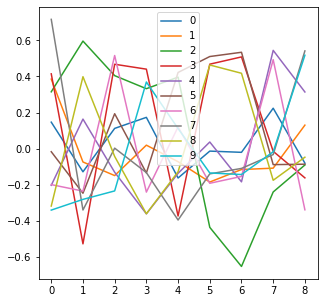

In [8]:
fig, ax = plt.subplots(figsize = (5.0, 5.0))
for i in range(10):
    ax.plot(z[i, 0:mm.y_dim].detach().to('cpu').numpy(), label = "%s" % i)
plt.legend()
plt.show()

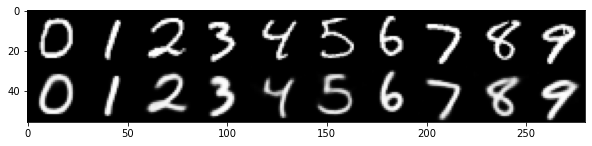

In [9]:
sample_data = []

sample_data.append(np.concatenate([test_data[i][0].numpy()[0,:,:] for i in target], axis = 1))
sample_data.append(np.concatenate([recon[i,:,:] for i in range(10)], axis = 1))
sample_data = np.concatenate(sample_data, axis = 0)
fig = plt.figure(figsize=(10.0,10.0))
plt.imshow(sample_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.show()

# Sample Generation

## 1. Exemplar Generation

In [10]:
from XAE.sampler import gaus

exn = 5

In [11]:
zz = torch.cat((torch.zeros(1,mm.z_dim), gaus(exn,mm.z_dim)), dim = 0).to(device)
new_z = torch.cat((z[:,0:mm.y_dim].repeat_interleave(exn + 1, dim = 0).to(device), zz.repeat((10, 1))), dim = 1)
new_x = mm.decode(new_z).squeeze(1).detach().to('cpu').numpy()

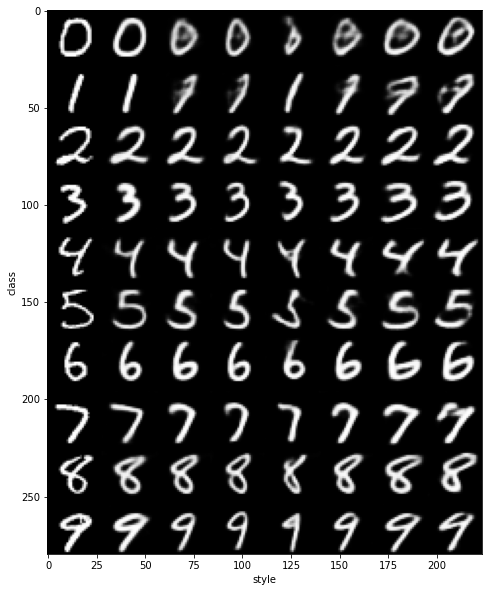

In [12]:
img_data = []
for i in range(10):
    img_data.append(np.concatenate([test_data[target[i]][0].numpy()[0,:,:]] + [recon[i,:,:]] + [new_x[(exn+1)*i + j] for j in range(exn+1)], axis = 1))
img_data = np.concatenate(img_data, axis = 0)

fig, ax = plt.subplots(figsize = (10.0, 10.0))
ax.imshow(img_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.xlabel('style')
plt.ylabel('class')
plt.show()

## 2. Style Transfer

In [13]:
new_z = torch.cat((z[:,:mm.y_dim].repeat_interleave(10, dim = 0), z[:,mm.y_dim:].repeat((10, 1))), dim = 1)
new_x = mm.decode(new_z).squeeze(1).detach().to('cpu').numpy()

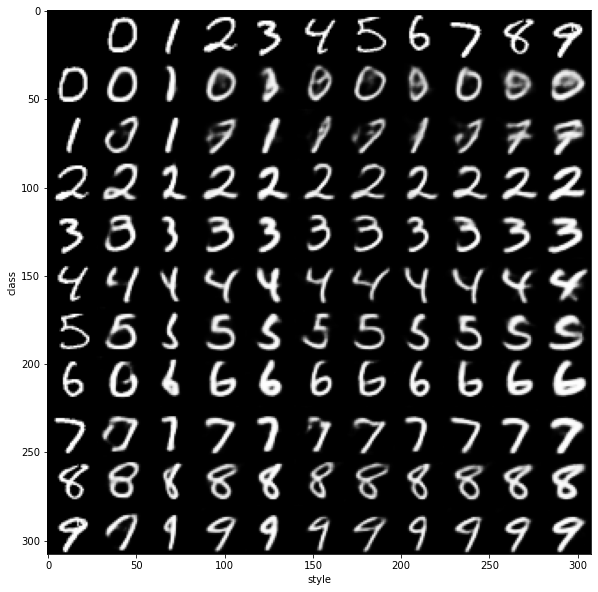

In [14]:
img_data = np.ones((28*11, 28*11))*-1
img_data[:28,28:] = np.concatenate([test_data[i][0].numpy()[0,:,:] for i in target], axis = 1)
for i in range(10):
    img_data[((i+1)*28):((i+2)*28),:28] = test_data[target[i]][0].numpy()[0,:,:]
    img_data[((i+1)*28):((i+2)*28),28:] = np.concatenate(new_x[(10*i):(10*(i+1)),:,:], axis = 1)

fig, ax = plt.subplots(figsize = (10.0, 10.0))
ax.imshow(img_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.xlabel('style')
plt.ylabel('class')
plt.show()